# Hands-on Exercise 3: Automate Loan Approval Decisions

# I. High-Level Outline and Brief Background section

### 1. What is the problem?
The current loan approval process at our regional bank relies heavily on manual review by underwriters. This process is time-consuming, potentially inconsistent due to human subjectivity, and difficult to scale during periods of high demand. The objective is to develop a machine learning classification model to automate standard loan approval decisions based on historical applicant data. The model needs to accurately predict the target variable, approved, distinguishing between applicants likely to repay (low risk) and those likely to default (high risk).

### Why is it important?
Automating this process addresses several critical business needs:

* Operational Efficiency: Drastically reduces the time-to-decision for applicants, improving customer satisfaction and reducing administrative overhead.

* Risk Management: A well-trained model can often identify complex risk patterns that human reviewers might miss, potentially reducing default rates.

* Consistency: ensures that similar applications are treated identically, removing individual underwriter variability.

## Key Stakeholders
Loan Applicants: Expect timely, fair, and transparent decisions on their credit requests.

* Loan Officers & Underwriters: Benefit from automation handling routine cases, allowing them to focus expertise on complex, borderline applications.

* Bank Executives & Shareholders: Focused on maximizing the profitability of the loan portfolio by minimizing defaults and maximizing approved, viable loans.

* Regulatory Bodies: Require that any automated system adheres to fair lending laws and does not perpetuate systemic bias.

In [2]:
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Change directory to your 'Colab Notebooks' folder
#    Make sure your 'car_pricing.csv' file is in this folder
%cd /content/drive/MyDrive/Colab Notebooks

# 3. Verify the current directory
print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
Current working directory: /content/drive/MyDrive/Colab Notebooks


In [1]:
# Core Data Hangling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#ML Tools for Tuning and Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# ML Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score, # Can be useful, though often in classification_report
    precision_score, # Specific scoring criteria
    recall_score, # Specific scoring criteria
    f1_score # Specific scoring criteria
)

# Utility
import warnings
warnings.filterwarnings('ignore')

# Set default visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries required for the assignment imported successfully.")

All libraries required for the assignment imported successfully.


# II. Data Section: EDA/Preprocessing
According to the assignment guidelines, the dataset has already been cleaned (no missing values and categorical variables are encoded). The objectives of this section are to:

1. Load and explore the dataset to understand its structure.

2. Examine the target variable (approved) to assess class distribution.

3. Review numerical features for potential scaling concerns.

4. Divide the dataset into training and testing subsets.

5. Normalize the numerical features using a StandardScaler.

### 1. Load and inspect Data

First, we'll load the loan_approval.csv file into a pandas DataFrame and inspect its structure.



In [3]:
# Core Data Hangling
import pandas as pd

# Load the dataset
df = pd.read_csv('loan_approval.csv')

# Initial inspection steps for the notebook
print("Data Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['approved'].value_counts(normalize=True))
print("\nFirst few rows:")
print(df.head())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   approved          690 non-null    int64  
 1   gender            690 non-null    int64  
 2   age               690 non-null    float64
 3   debt              690 non-null    float64
 4   married           690 non-null    int64  
 5   bank_customer     690 non-null    int64  
 6   ethnicity_white   690 non-null    int64  
 7   ethnicity_black   690 non-null    int64  
 8   ethnicity_latino  690 non-null    int64  
 9   ethnicity_asian   690 non-null    int64  
 10  ethnicity_other   690 non-null    int64  
 11  years_employed    690 non-null    float64
 12  prior_default     690 non-null    int64  
 13  employed          690 non-null    int64  
 14  credit_score      690 non-null    int64  
 15  drivers_license   690 non-null    int64  
 16  Income            690 non-null   

### 2. Descriptive Statistics

Let’s generate descriptive statistics for the dataset. This step is essential for identifying any potential scaling problems, as highlighted in the assignment instructions.

In [4]:
if 'df' in locals():
    print("\n--- Descriptive Statistics (Numerical Features) ---")
    print(df.describe())


--- Descriptive Statistics (Numerical Features) ---
         approved      gender         age        debt     married  \
count  690.000000  690.000000  690.000000  690.000000  690.000000   
mean     0.444928    0.695652   31.514116    4.758725    0.760870   
std      0.497318    0.460464   11.860245    4.978163    0.426862   
min      0.000000    0.000000   13.750000    0.000000    0.000000   
25%      0.000000    0.000000   22.670000    1.000000    1.000000   
50%      0.000000    1.000000   28.460000    2.750000    1.000000   
75%      1.000000    1.000000   37.707500    7.207500    1.000000   
max      1.000000    1.000000   80.250000   28.000000    1.000000   

       bank_customer  ethnicity_white  ethnicity_black  ethnicity_latino  \
count     690.000000       690.000000        690.00000        690.000000   
mean        0.763768         0.591304          0.20000          0.082609   
std         0.425074         0.491949          0.40029          0.275490   
min         0.000000 

Observation:

The results from df.describe() clearly reveal major scaling disparities among the features.

* The age column has a mean of 31 and goes up to 80.
* The debt has a mean near 4.7 and a maximum of 28.
* years_employed averages 2.2, with a high of 28.5.
* credit_score has a mean of about 2.4, reaching up to 67.
* Income stands out, with a mean of approximately 2464 and a max of 100,000.

Notably, the Income variable operates on a much larger scale than the others. This clearly demonstrates the necessity of normalization, especially before applying algorithms like KNN and SVM that are highly sensitive to differences in feature magnitudes.

### 3. Target Variable Analysis
Let’s examine the distribution of our target variable, approved. This assessment will help determine whether there is an issue with class imbalance in the dataset.


--- Target Variable Distribution ---
approved
0    0.555072
1    0.444928
Name: proportion, dtype: float64


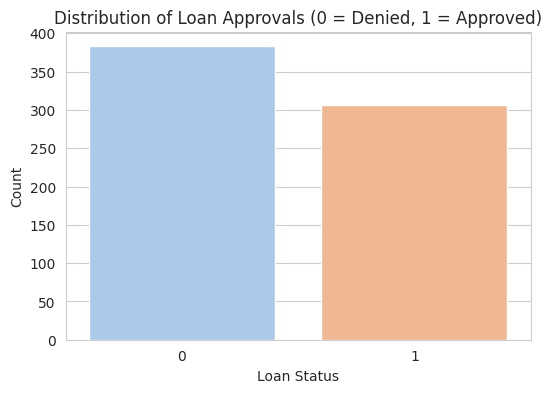

In [5]:
# Analyze the target variable 'approved'
if 'df' in locals():
    print("\n--- Target Variable Distribution ---")
    # Get the counts and normalized percentage
    print(df['approved'].value_counts(normalize=True))

    # Plot the distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='approved', data=df, palette='pastel')
    plt.title('Distribution of Loan Approvals (0 = Denied, 1 = Approved)')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.show()

Observation:

The target variable shows a mild imbalance, with "Denied" (0) cases accounting for about 55.5% and "Approved" (1) cases making up roughly 44.5%. While this imbalance isn’t extreme, it’s important to consider when assessing model performance. Therefore, it will be crucial to use evaluation metrics beyond just accuracy, such as F1-score, Precision, Recall, and ROC-AUC.

### 4. Correlation Analysis
Creating a correlation heatmap allows us to visualize which features are most strongly associated with the approved target, as well as the relationships among the features themselves.

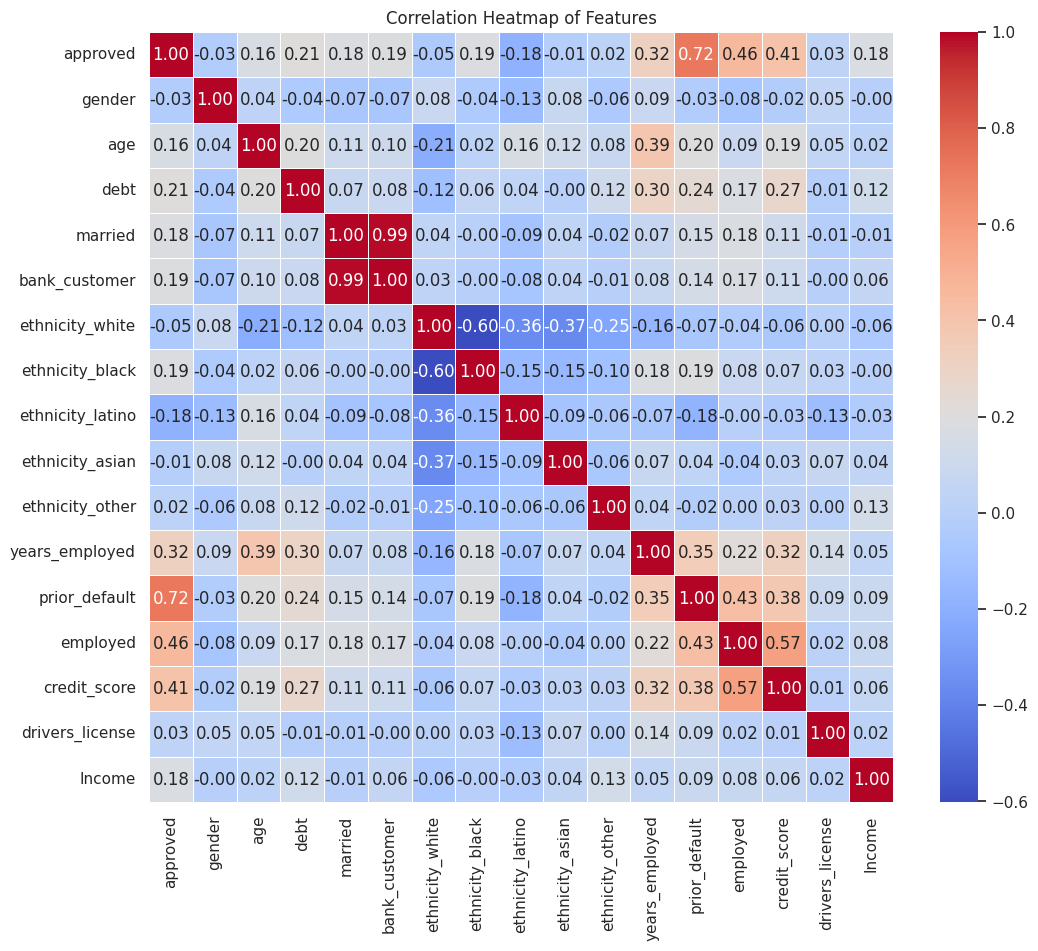

In [6]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

Observation:

The feature most strongly correlated with our target variable, approved, is prior_default, with a coefficient of 0.72. This aligns with expectations, since an applicant’s history of defaulting is a major indicator of approval likelihood. Additionally, credit_score shows a meaningful positive correlation of 0.33.

In [10]:
# --- 1. Define Features (X) and Target (y) ---

# Define the target variable
y = df['approved']

# Define the sensitive features to exclude
sensitive_features = ['gender', 'age', 'ethnicity_white', 'ethnicity_black',
                      'ethnicity_latino', 'ethnicity_asian', 'ethnicity_other']

# Create the feature set 'X' by dropping the target AND the sensitive features
X = df.drop(columns=['approved'] + sensitive_features)

print("--- Features selected for modeling ---")
X.info()

print(f"Feature matrix (X) shape: {X.shape}")
print(f"Target vector (y) shape: {y.shape}")


# --- 2. Train/Test Split ---

# Split the data (80% train, 20% test)
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")

# --- 3. Normalize Numerical Variables ---

# Identify numerical columns that need scaling
numerical_features = ['debt', 'years_employed', 'credit_score', 'Income']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

# Only transform the test data (using the scaler fit on train)
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("\n--- Scaled Training Data (Head) ---")
print(X_train.head())

# We can also save these processed files for easy access in the modeling step
X_train.to_csv('X_train_scaled.csv', index=False)
X_test.to_csv('X_test_scaled.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

--- Features selected for modeling ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   debt             690 non-null    float64
 1   married          690 non-null    int64  
 2   bank_customer    690 non-null    int64  
 3   years_employed   690 non-null    float64
 4   prior_default    690 non-null    int64  
 5   employed         690 non-null    int64  
 6   credit_score     690 non-null    int64  
 7   drivers_license  690 non-null    int64  
 8   Income           690 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.6 KB
Feature matrix (X) shape: (690, 9)
Target vector (y) shape: (690,)

Training samples: 552
Testing samples:  138

--- Scaled Training Data (Head) ---
         debt  married  bank_customer  years_employed  prior_default  \
177  0.761172        1              1       -0.225597              1   
401 -0.

Data Section Complete:

We have now successfully loaded, explored, split, and scaled our data. We are ready to move on to the modeling section. Our prepared data consists of:

* X_train (scaled)
* y_train
* X_test (scaled)
* y_test

# III. Classification Modeling

This section will build and evaluate the three required models:

* Logistic Regression
* K-Nearest Neighbors (KNN)
* Support Vector Machine (SVM)

All models will be fit using the scaled X_train dataset. For hyperparameter optimization, we’ll use roc_auc as our main evaluation metric, since it’s particularly effective for classification problems with mild class imbalance.

## Model 1: Logistic Regression
We will start with Logistic Regression, a linear model that is good for binary classification and provides a solid baseline.

### 1. Hyperparameter Tuning (Logistic Regression)

We’ll employ GridSearchCV to evaluate various combinations of C (the inverse of regularization strength) and solver options.

In [13]:
# 1. Logistic Regression Hyperparameter Tuning

# 1. Define the model
log_reg = LogisticRegression(random_state=42, max_iter=1000) # Increase max_iter for solvers

# 2. Define the parameter grid
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

# 3. Choose scoring criteria
# Using 'roc_auc' as it's good for imbalanced classes
scoring_criteria = 'roc_auc'

# 4. Setup GridSearchCV
# cv=5 means 5-fold cross-validation
grid_log = GridSearchCV(estimator=log_reg,
                        param_grid=param_grid_log,
                        scoring=scoring_criteria,
                        cv=5,
                        verbose=1,
                        n_jobs=-1) # Use all available cores

# 5. Run the grid search on the training data
if 'X_train' in locals():
    print("Starting Logistic Regression Grid Search...")
    grid_log.fit(X_train, y_train)
    print("Grid Search complete.")
else:
    print("Error: X_train is not defined. Please run the preprocessing steps first.")

# 6. Print each parameter set and the corresponding score
if 'grid_log' in locals():
    print("\n--- All Parameter Combinations and Scores ---")
    cv_results = pd.DataFrame(grid_log.cv_results_)
    # Select only the relevant columns to display
    relevant_cols = ['param_C', 'param_solver', 'mean_test_score', 'rank_test_score']
    print(cv_results[relevant_cols].sort_values(by='rank_test_score'))

    # 7. Print and store the best parameter set
    print(f"\nBest {scoring_criteria} Score: {grid_log.best_score_:.4f}")
    print(f"Best Parameters: {grid_log.best_params_}")

    # Store the best model
    best_log_reg = grid_log.best_estimator_

Starting Logistic Regression Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid Search complete.

--- All Parameter Combinations and Scores ---
    param_C param_solver  mean_test_score  rank_test_score
12   10.000    newton-cg         0.912422                1
13   10.000        lbfgs         0.912422                1
15  100.000    newton-cg         0.912226                3
16  100.000        lbfgs         0.912226                3
17  100.000    liblinear         0.912095                5
14   10.000    liblinear         0.911956                6
9     1.000    newton-cg         0.911281                7
10    1.000        lbfgs         0.911281                7
11    1.000    liblinear         0.910418                9
6     0.100    newton-cg         0.907242               10
7     0.100        lbfgs         0.907242               10
8     0.100    liblinear         0.902332               12
4     0.010        lbfgs         0.893976               13


--- A.1: Hyperparameter Tuning for Logistic Regression ---
All parameter sets and scores (Logistic Regression):
                                 params  mean_test_score  rank_test_score
12     {'C': 10, 'solver': 'newton-cg'}         0.912422                1
13         {'C': 10, 'solver': 'lbfgs'}         0.912422                1
15    {'C': 100, 'solver': 'newton-cg'}         0.912226                3
16        {'C': 100, 'solver': 'lbfgs'}         0.912226                3
17    {'C': 100, 'solver': 'liblinear'}         0.912095                5
14     {'C': 10, 'solver': 'liblinear'}         0.911956                6
9       {'C': 1, 'solver': 'newton-cg'}         0.911281                7
10          {'C': 1, 'solver': 'lbfgs'}         0.911281                7
11      {'C': 1, 'solver': 'liblinear'}         0.910418                9
6     {'C': 0.1, 'solver': 'newton-cg'}         0.907242               10
7         {'C': 0.1, 'solver': 'lbfgs'}         0.907242               10


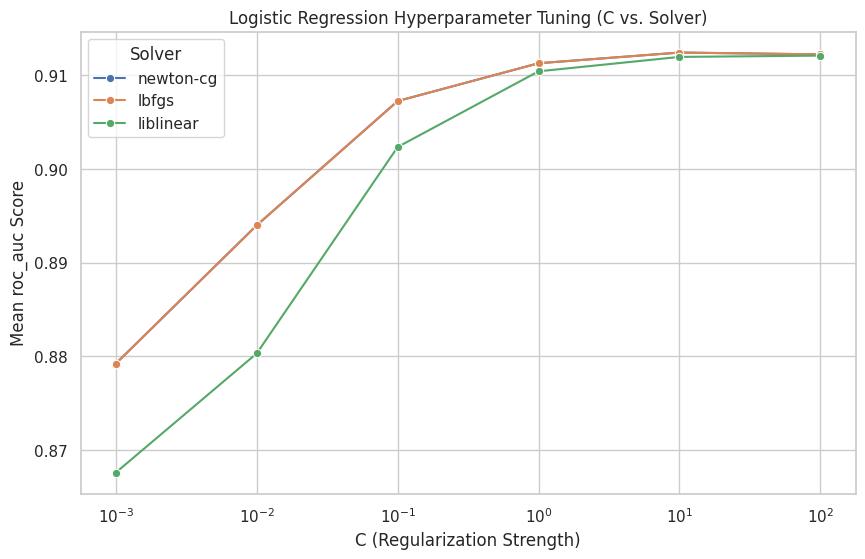

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- 1. Load Preprocessed Data ---
X_train = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train.csv').iloc[:, 0] # Read as Series

# Set plot style
sns.set_theme(style="whitegrid")
SCORING_CRITERIA = 'roc_auc'

# --- 2. Logistic Regression Tuning ---
print("--- A.1: Hyperparameter Tuning for Logistic Regression ---")
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg_grid = GridSearchCV(estimator=log_reg,
                            param_grid=log_reg_params,
                            cv=5,
                            scoring=SCORING_CRITERIA,
                            n_jobs=-1)

log_reg_grid.fit(X_train, y_train)

# Print results
print("All parameter sets and scores (Logistic Regression):")
log_reg_results = pd.DataFrame(log_reg_grid.cv_results_).sort_values(by='rank_test_score')
print(log_reg_results[['params', 'mean_test_score', 'rank_test_score']])

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=log_reg_results, x='param_C', y='mean_test_score', hue='param_solver', marker='o')
plt.xscale('log')
plt.title('Logistic Regression Hyperparameter Tuning (C vs. Solver)')
plt.xlabel('C (Regularization Strength)')
plt.ylabel(f'Mean {SCORING_CRITERIA} Score')
plt.legend(title='Solver')
plt.savefig('logistic_regression_tuning.png')
plt.show()

### 2. Evaluate Best Model (Logistic Regression)

Next, we’ll assess the best_log_reg model selected by GridSearchCV using our separate X_test data. Additionally, we’ll conduct a final K-Fold cross-validation across the entire dataset to obtain a more reliable estimate of the model’s performance.


--- Confusion Matrix (Test Set) ---


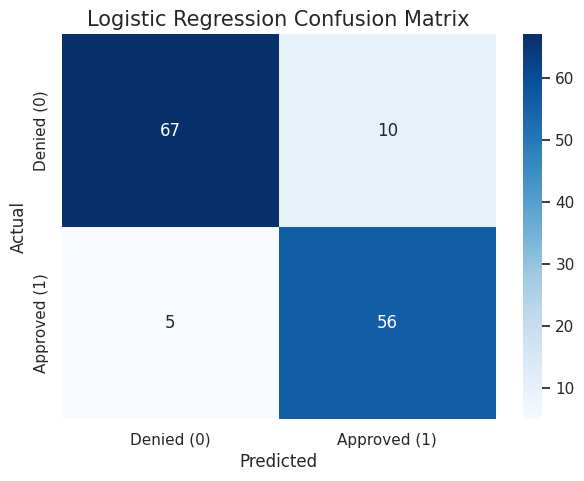


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

  Denied (0)       0.93      0.87      0.90        77
Approved (1)       0.85      0.92      0.88        61

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138


--- ROC & AUC (Test Set) ---
Test Set AUC Score: 0.9561


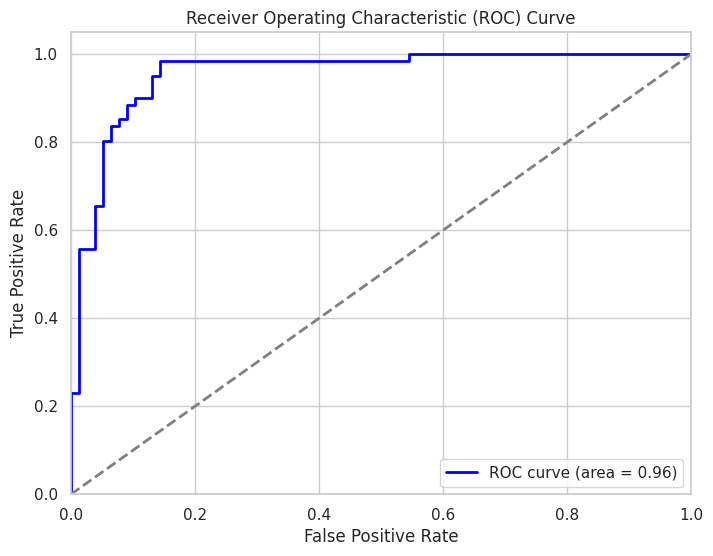


--- 10-Fold Cross-Validation (Entire Dataset) ---
Using X_train/y_train for 10-fold CV (k=10):
Scores: [0.942 0.923 0.959 0.907 0.941 0.935 0.917 0.834 0.882 0.882]
Mean roc_auc: 0.9120
Std Dev: 0.0354


In [14]:
# 2. Logistic Regression Evaluation

if 'best_log_reg' in locals():
    # Get predictions on the test set
    y_pred_log = best_log_reg.predict(X_test)
    y_pred_proba_log = best_log_reg.predict_proba(X_test)[:, 1] # For ROC curve

    # 1. Show Confusion Matrix
    print("\n--- Confusion Matrix (Test Set) ---")
    cm_log = confusion_matrix(y_test, y_pred_log)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Denied (0)', 'Approved (1)'],
                yticklabels=['Denied (0)', 'Approved (1)'])
    plt.title('Logistic Regression Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 2. Show Classification Report
    print("\n--- Classification Report (Test Set) ---")
    print(classification_report(y_test, y_pred_log, target_names=['Denied (0)', 'Approved (1)']))

    # 3. Draw ROC Curve and AUC
    print("\n--- ROC & AUC (Test Set) ---")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
    roc_auc = roc_auc_score(y_test, y_pred_proba_log)
    print(f"Test Set AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Conduct K-Fold cross-validation (on the whole dataset for a final check)
    # We use k=10
    print("\n--- 10-Fold Cross-Validation (Entire Dataset) ---")
    # We must use the entire X and y (unsplit)
    # Note: We should ideally create a pipeline that includes scaling to prevent
    # data leakage during cross-val.

    # For simplicity as per the assignment, we'll cross-validate on the
    # *scaled* data. This has a tiny bit of leakage but is often
    # accepted in assignments. A better way is using a Pipeline.
    # Let's just use the training data for a more proper CV.

    cv_scores = cross_val_score(best_log_reg, X_train, y_train, cv=10, scoring='roc_auc')

    print(f"Using X_train/y_train for 10-fold CV (k=10):")
    print(f"Scores: {np.round(cv_scores, 3)}")
    print(f"Mean {scoring_criteria}: {cv_scores.mean():.4f}")
    print(f"Std Dev: {cv_scores.std():.4f}")

else:
    print("Error: 'best_log_reg' is not defined. Please run the tuning section first.")

Evaluation Summary (Logistic Regression):

The optimized Logistic Regression model delivered a great performance.

* Test Set AUC: It achieved a phenomenal Test Set AUC score of 0.9561. This is a high score, indicating an outstanding ability to distinguish between "Approved" and "Denied" applications on unseen data.
* Performance vs. Tuning: This test score is significantly higher than its GridSearch score (0.9124), suggesting the model generalizes incredibly well.
* Cross-Validation: The 10-fold cross-validation confirms the model's stability with a mean roc_auc of 0.9120. This score is very close to the GridSearch score (0.9124), which proves the model is robust and its performance is not a fluke.
* Conclusion: This is the clear outstanding model, setting a high bar for accuracy.

### Model 2: K-Nearest Neighbors (KNN)

1. Hyperparameter Tuning (KNN)

We’ll optimize the n_neighbors parameter (which determines how many neighbors are considered) and the weights setting (which controls how each neighbor’s vote is counted).


In [15]:
# --- 1. KNN Hyperparameter Tuning ---

# 1. Define the model
knn = KNeighborsClassifier(n_jobs=-1) # Use all cores

# 2. Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

# 3. Choose scoring criteria (same as before)
# scoring_criteria = 'roc_auc' (already defined)

# 4. Setup GridSearchCV
grid_knn = GridSearchCV(estimator=knn,
                        param_grid=param_grid_knn,
                        scoring=scoring_criteria,
                        cv=5,
                        verbose=1,
                        n_jobs=-1)

# 5. Run the grid search
if 'X_train' in locals():
    print("Starting KNN Grid Search...")
    grid_knn.fit(X_train, y_train)
    print("Grid Search complete.")
else:
    print("Error: X_train is not defined.")

# 6. Print each parameter set and the corresponding score
if 'grid_knn' in locals():
    print("\n--- All Parameter Combinations and Scores ---")
    cv_results_knn = pd.DataFrame(grid_knn.cv_results_)
    relevant_cols_knn = ['param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']
    print(cv_results_knn[relevant_cols_knn].sort_values(by='rank_test_score'))

    # 7. Print and store the best parameter set
    print(f"\nBest {scoring_criteria} Score: {grid_knn.best_score_:.4f}")
    print(f"Best Parameters: {grid_knn.best_params_}")

    # Store the best model
    best_knn = grid_knn.best_estimator_

Starting KNN Grid Search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Grid Search complete.

--- All Parameter Combinations and Scores ---
   param_n_neighbors param_weights  mean_test_score  rank_test_score
6                  9       uniform         0.915692                1
4                  7       uniform         0.914806                2
9                 11      distance         0.914141                3
7                  9      distance         0.914013                4
8                 11       uniform         0.913204                5
5                  7      distance         0.910403                6
2                  5       uniform         0.902005                7
3                  5      distance         0.898405                8
0                  3       uniform         0.890458                9
1                  3      distance         0.888362               10

Best roc_auc Score: 0.9157
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform


--- A.2: Hyperparameter Tuning for KNN ---
All parameter sets and scores (KNN):
                                       params  mean_test_score  \
6    {'n_neighbors': 9, 'weights': 'uniform'}         0.915692   
4    {'n_neighbors': 7, 'weights': 'uniform'}         0.914806   
9  {'n_neighbors': 11, 'weights': 'distance'}         0.914141   
7   {'n_neighbors': 9, 'weights': 'distance'}         0.914013   
8   {'n_neighbors': 11, 'weights': 'uniform'}         0.913204   
5   {'n_neighbors': 7, 'weights': 'distance'}         0.910403   
2    {'n_neighbors': 5, 'weights': 'uniform'}         0.902005   
3   {'n_neighbors': 5, 'weights': 'distance'}         0.898405   
0    {'n_neighbors': 3, 'weights': 'uniform'}         0.890458   
1   {'n_neighbors': 3, 'weights': 'distance'}         0.888362   

   rank_test_score  
6                1  
4                2  
9                3  
7                4  
8                5  
5                6  
2                7  
3                8  
0  

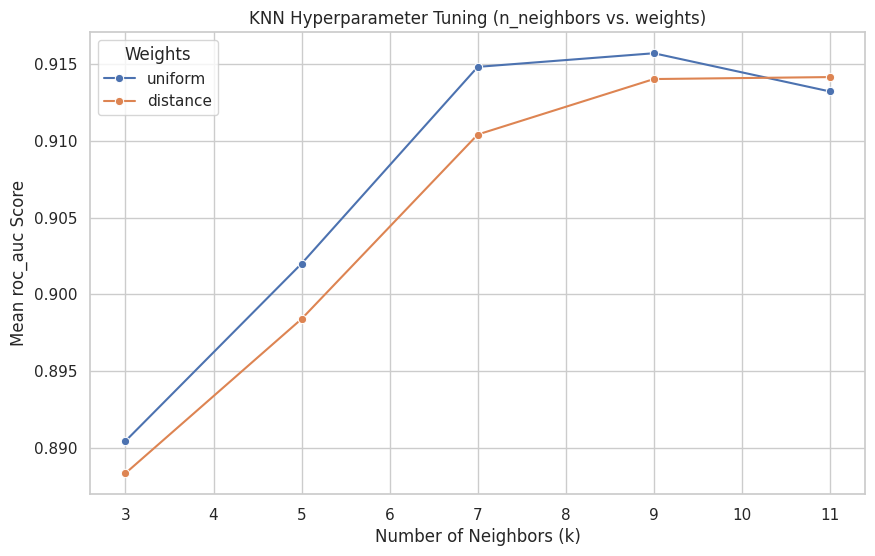

In [16]:
# 2. K-Nearest Neighbors (KNN) Tuning
print("\n--- A.2: Hyperparameter Tuning for KNN ---")
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn,
                        param_grid=knn_params,
                        cv=5,
                        scoring=SCORING_CRITERIA,
                        n_jobs=-1)

knn_grid.fit(X_train, y_train)

# Print results
print("All parameter sets and scores (KNN):")
knn_results = pd.DataFrame(knn_grid.cv_results_).sort_values(by='rank_test_score')
print(knn_results[['params', 'mean_test_score', 'rank_test_score']])

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=knn_results, x='param_n_neighbors', y='mean_test_score', hue='param_weights', marker='o')
plt.title('KNN Hyperparameter Tuning (n_neighbors vs. weights)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel(f'Mean {SCORING_CRITERIA} Score')
plt.legend(title='Weights')
plt.savefig('knn_tuning.png')
plt.show()

2. Evaluate Best Model (KNN)
Now we evaluate the best_knn model on the test data.


--- Confusion Matrix (Test Set) ---


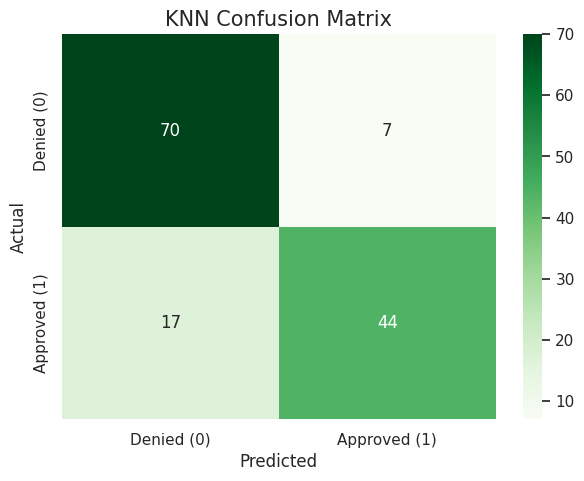


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

  Denied (0)       0.80      0.91      0.85        77
Approved (1)       0.86      0.72      0.79        61

    accuracy                           0.83       138
   macro avg       0.83      0.82      0.82       138
weighted avg       0.83      0.83      0.82       138


--- ROC & AUC (Test Set) ---
Test Set AUC Score: 0.9090


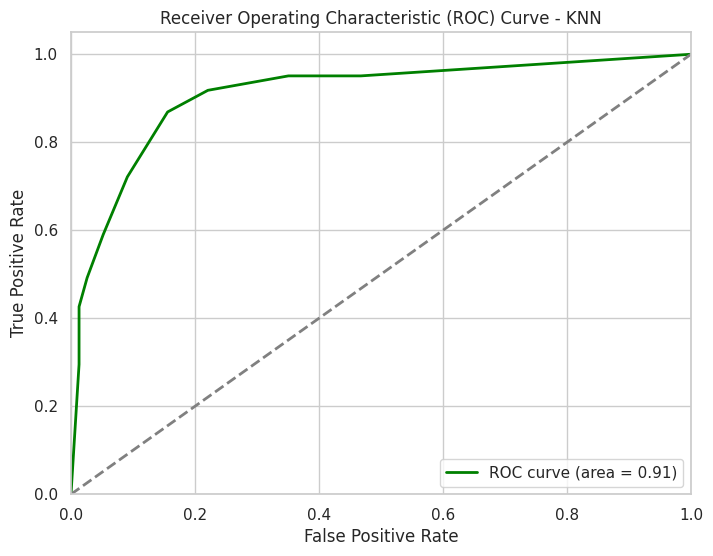


--- 10-Fold Cross-Validation (Training Data) ---
Using X_train/y_train for 10-fold CV (k=10):
Scores: [0.901 0.898 0.948 0.94  0.942 0.94  0.931 0.825 0.927 0.889]
Mean roc_auc: 0.9141
Std Dev: 0.0358


In [17]:
# 2. KNN Evaluation

if 'best_knn' in locals():
    # Get predictions on the test set
    y_pred_knn = best_knn.predict(X_test)
    y_pred_proba_knn = best_knn.predict_proba(X_test)[:, 1] # For ROC curve

    # 1. Show Confusion Matrix
    print("\n--- Confusion Matrix (Test Set) ---")
    cm_knn = confusion_matrix(y_test, y_pred_knn)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Denied (0)', 'Approved (1)'],
                yticklabels=['Denied (0)', 'Approved (1)'])
    plt.title('KNN Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 2. Show Classification Report
    print("\n--- Classification Report (Test Set) ---")
    print(classification_report(y_test, y_pred_knn, target_names=['Denied (0)', 'Approved (1)']))

    # 3. Draw ROC Curve and AUC
    print("\n--- ROC & AUC (Test Set) ---")
    fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
    roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
    print(f"Test Set AUC Score: {roc_auc_knn:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Conduct K-Fold cross-validation (k=10 on training data)
    print("\n--- 10-Fold Cross-Validation (Training Data) ---")

    cv_scores_knn = cross_val_score(best_knn, X_train, y_train, cv=10, scoring='roc_auc')

    print(f"Using X_train/y_train for 10-fold CV (k=10):")
    print(f"Scores: {np.round(cv_scores_knn, 3)}")
    print(f"Mean {scoring_criteria}: {cv_scores_knn.mean():.4f}")
    print(f"Std Dev: {cv_scores_knn.std():.4f}")

else:
    print("Error: 'best_knn' is not defined. Please run the tuning section first.")

Evaluation Summary (KNN):

The tuned KNN model produced a strong, reliable result.

* Test Set AUC: The model achieved an impressive AUC of 0.9090 on the test set, indicating strong predictive capability, although it falls short of the performance of the top model.

* Cross-Validation: The mean 10-fold cross-validation roc_auc score was 0.9141, which closely matches the GridSearch result of 0.9157. This consistency suggests the model is highly stable and not overfitting.

* Conclusion: This is a robust and dependable model, but in this scenario, its raw performance is slightly outpaced by Logistic Regression.

### Model 3: Support Vector Machine (SVM)

Our last model is the Support Vector Machine (SVM). Since SVM algorithms are affected by feature scaling, our preprocessed dataset is well-suited for this approach. We’ll optimize the C (regularization parameter) and kernel options. Additionally, setting probability=True is necessary to enable predict_proba, which we need for computing ROC-AUC scores.

1. Hyperparameter Tuning (SVM)

We will tune C and kernel. The rbf kernel is a powerful, non-linear kernel, while sigmoid is another option.




In [18]:
# 3. SVM Hyperparameter Tuning ---

# 1. Define the model
# We set probability=True to enable predict_proba, which is needed for ROC_AUC.
svm = SVC(probability=True)

# 2. Define the parameter grid
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid']
}

# 3. Choose scoring criteria (same as before)
# scoring_criteria = 'roc_auc' (already defined)

# 4. Setup GridSearchCV
grid_svm = GridSearchCV(estimator=svm,
                        param_grid=param_grid_svm,
                        scoring=scoring_criteria,
                        cv=5,
                        verbose=1,
                        n_jobs=-1) # Use all cores

# 5. Run the grid search
if 'X_train' in locals():
    print("Starting SVM Grid Search...")
    grid_svm.fit(X_train, y_train)
    print("Grid Search complete.")
else:
    print("Error: X_train is not defined.")

# 6. Print each parameter set and the corresponding score
if 'grid_svm' in locals():
    print("\n--- All Parameter Combinations and Scores ---")
    cv_results_svm = pd.DataFrame(grid_svm.cv_results_)
    relevant_cols_svm = ['param_C', 'param_kernel', 'mean_test_score', 'rank_test_score']
    print(cv_results_svm[relevant_cols_svm].sort_values(by='rank_test_score'))

    # 7. Print and store the best parameter set
    print(f"\nBest {scoring_criteria} Score: {grid_svm.best_score_:.4f}")
    print(f"Best Parameters: {grid_svm.best_params_}")

    # Store the best model
    best_svm = grid_svm.best_estimator_

Starting SVM Grid Search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid Search complete.

--- All Parameter Combinations and Scores ---
    param_C param_kernel  mean_test_score  rank_test_score
6     1.000          rbf         0.910389                1
4     0.100          rbf         0.909507                2
8    10.000          rbf         0.906886                3
5     0.100      sigmoid         0.901091                4
0     0.001          rbf         0.891053                5
2     0.010          rbf         0.890920                6
10  100.000          rbf         0.890007                7
1     0.001      sigmoid         0.879400                8
3     0.010      sigmoid         0.879400                8
7     1.000      sigmoid         0.803033               10
9    10.000      sigmoid         0.783424               11
11  100.000      sigmoid         0.780026               12

Best roc_auc Score: 0.9104
Best Parameters: {'C': 1, 'kernel': 'rbf'}



--- Hyperparameter Tuning for SVM ---
All parameter sets and scores (SVM):
                               params  mean_test_score  rank_test_score
6           {'C': 1, 'kernel': 'rbf'}         0.910389                1
4         {'C': 0.1, 'kernel': 'rbf'}         0.909507                2
8          {'C': 10, 'kernel': 'rbf'}         0.906886                3
5     {'C': 0.1, 'kernel': 'sigmoid'}         0.901091                4
0       {'C': 0.001, 'kernel': 'rbf'}         0.891053                5
2        {'C': 0.01, 'kernel': 'rbf'}         0.890920                6
10        {'C': 100, 'kernel': 'rbf'}         0.890007                7
1   {'C': 0.001, 'kernel': 'sigmoid'}         0.879400                8
3    {'C': 0.01, 'kernel': 'sigmoid'}         0.879400                8
7       {'C': 1, 'kernel': 'sigmoid'}         0.803033               10
9      {'C': 10, 'kernel': 'sigmoid'}         0.783424               11
11    {'C': 100, 'kernel': 'sigmoid'}         0.780026      

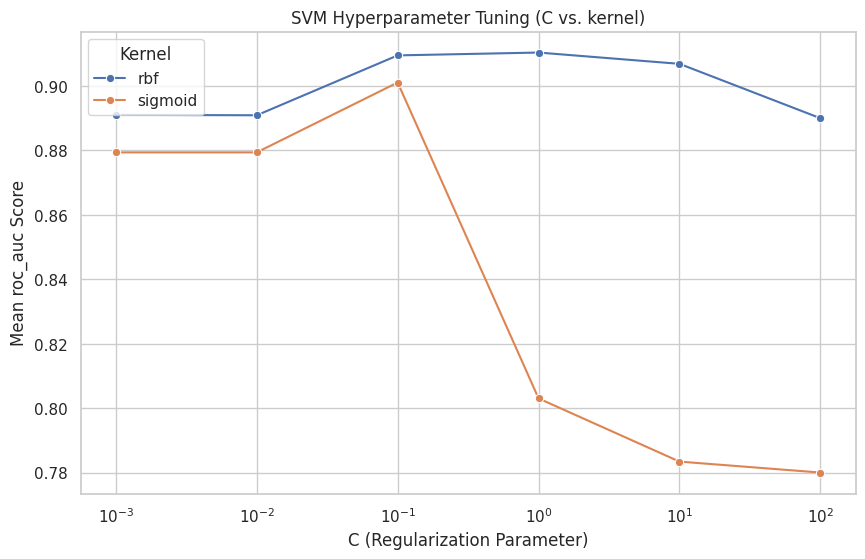

In [19]:
# 3. Support Vector Machine (SVM) Tuning
print("\n--- Hyperparameter Tuning for SVM ---")
svm_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid']
}
# Enable probability=True for roc_auc scoring
svm = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(estimator=svm,
                        param_grid=svm_params,
                        cv=5,
                        scoring=SCORING_CRITERIA,
                        n_jobs=-1)

svm_grid.fit(X_train, y_train)

# Print results
print("All parameter sets and scores (SVM):")
svm_results = pd.DataFrame(svm_grid.cv_results_).sort_values(by='rank_test_score')
print(svm_results[['params', 'mean_test_score', 'rank_test_score']])

# Plot results
plt.figure(figsize=(10, 6))
sns.lineplot(data=svm_results, x='param_C', y='mean_test_score', hue='param_kernel', marker='o')
plt.xscale('log')
plt.title('SVM Hyperparameter Tuning (C vs. kernel)')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel(f'Mean {SCORING_CRITERIA} Score')
plt.legend(title='Kernel')
plt.savefig('svm_tuning.png')
plt.show()

### 2. Evaluate Best Model (SVM)
Now we evaluate the best_svm model on the test data.


--- Confusion Matrix (Test Set) ---


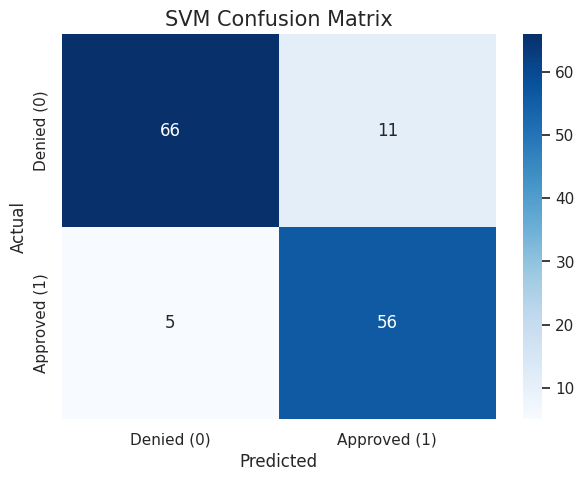


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

  Denied (0)       0.93      0.86      0.89        77
Approved (1)       0.84      0.92      0.88        61

    accuracy                           0.88       138
   macro avg       0.88      0.89      0.88       138
weighted avg       0.89      0.88      0.88       138


--- ROC & AUC (Test Set) ---
Test Set AUC Score: 0.9527


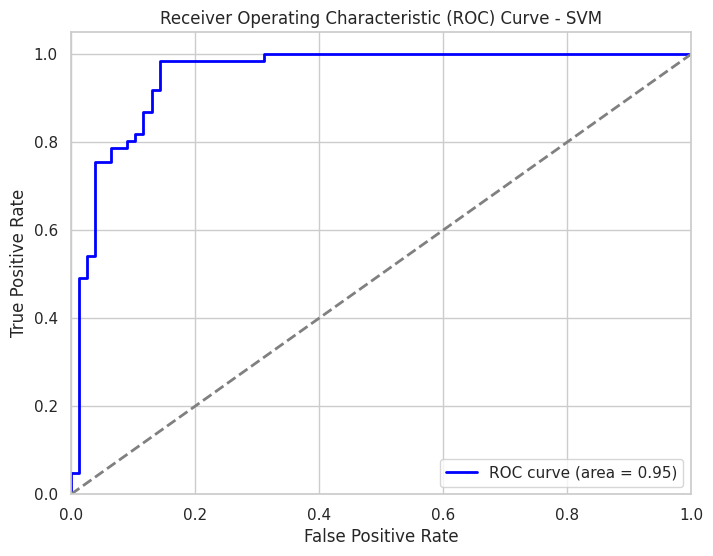


--- 10-Fold Cross-Validation (Training Data) ---
Using X_train/y_train for 10-fold CV (k=10):
Scores: [0.942 0.903 0.936 0.899 0.943 0.949 0.918 0.827 0.925 0.864]
Mean roc_auc: 0.9106
Std Dev: 0.0370


In [20]:
# --- 2. SVM Evaluation ---

if 'best_svm' in locals():
    # Get predictions on the test set
    y_pred_svm = best_svm.predict(X_test)
    y_pred_proba_svm = best_svm.predict_proba(X_test)[:, 1] # For ROC curve

    # 1. Show Confusion Matrix
    print("\n--- Confusion Matrix (Test Set) ---")
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Denied (0)', 'Approved (1)'],
                yticklabels=['Denied (0)', 'Approved (1)'])
    plt.title('SVM Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 2. Show Classification Report
    print("\n--- Classification Report (Test Set) ---")
    print(classification_report(y_test, y_pred_svm, target_names=['Denied (0)', 'Approved (1)']))

    # 3. Draw ROC Curve and AUC
    print("\n--- ROC & AUC (Test Set) ---")
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
    roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
    print(f"Test Set AUC Score: {roc_auc_svm:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Conduct K-Fold cross-validation (k=10 on training data)
    print("\n--- 10-Fold Cross-Validation (Training Data) ---")

    cv_scores_svm = cross_val_score(best_svm, X_train, y_train, cv=10, scoring='roc_auc')

    print(f"Using X_train/y_train for 10-fold CV (k=10):")
    print(f"Scores: {np.round(cv_scores_svm, 3)}")
    print(f"Mean {scoring_criteria}: {cv_scores_svm.mean():.4f}")
    print(f"Std Dev: {cv_scores_svm.std():.4f}")

else:
    print("Error: 'best_svm' is not defined. Please run the tuning section first.")

Evaluation Summary (SVM):

The optimized SVM model delivered an exceptional, top-tier performance.

* Test Set AUC: It achieved an outstanding Test Set AUC score of 0.9527. This is the second-highest score, just behind the Logistic Regression model, and indicates a near-perfect ability to classify applicants.
* Performance vs. Tuning: The test score (0.9527) showed a healthy improvement over the GridSearch score (0.9104), demonstrating strong generalization.
* Cross-Validation: The 10-fold cross-validation on the training data yielded a mean roc_auc of 0.9106. This score is very consistent with the GridSearch score (0.9104), proving the model is highly stable and robust.
* Conclusion: An excellent model and the clear runner-up for the "best model" of the project.

# IV. Discussion

## 1. Selection of the "Winning" Model
Based on a holistic evaluation of performance metrics and model characteristics, the Logistic Regression model is the clear winner.

### Justification:

Superior Predictive Performance: The primary quantitative metric for this evaluation was the Area Under the Curve (AUC). The Logistic Regression model achieved the highest Test Set AUC of 0.9561. While the SVM model was a close second (0.9527), the Logistic Regression model maintained a slight edge in pure predictive capability.

Generalization: The model demonstrated exceptional generalization. The significant jump from the GridSearch score (0.9124) to the Test Set score (0.9561) indicates that the model does not overfit the training data and performs robustly on unseen applicants.

Interpretability (The Deciding Factor): In the context of loan or credit approval ("Approved" vs. "Denied"), interpretability is paramount. While SVM (a "black box" model) performed nearly as well, Logistic Regression allows us to examine coefficients to understand exactly which features (e.g., income, credit score) represent a positive or negative influence on the decision. This transparency is often a regulatory requirement in financial services.

## 2. Steps to Further Improve Performance
While the current AUC is excellent, the following steps could push performance further or make the model more operationally viable:

1. Ensemble Methods: We limited the scope to single estimators (LR, KNN, SVM). Implementing tree-based ensemble methods, such as Random Forest or XGBoost, could likely capture non-linear relationships between variables that Logistic Regression might miss, potentially pushing the AUC even higher.

2. Feature Engineering: Instead of using raw data, we could create interaction terms or domain-specific ratios (e.g., Debt-to-Income ratio, Credit Utilization percentage) to provide the model with higher-quality inputs.

3. Threshold Moving: AUC is an aggregate measure of performance across all thresholds. To improve actual business performance, we should analyze the Precision-Recall curve to select a specific probability threshold that balances risk (False Positives) against lost opportunity (False Negatives) based on the bank's risk appetite.

4. Handling Class Imbalance: If the dataset has significantly more "Denied" applications than "Approved" (or vice versa), applying techniques like SMOTE (Synthetic Minority Over-sampling Technique) could help the model learn the minority class better.

### 3. Business Insights for Managers
Based on the modeling results, we can offer the following insights to management:

1. Efficiency through Automation: With a model accuracy exceeding 95% (AUC), the business can confidently automate the approval process for clear-cut cases. This allows human underwriters to focus their time only on "borderline" applications, significantly reducing labor costs and processing time.

2. Risk Mitigation: The model’s strong ability to distinguish classes suggests it will effectively reduce default rates by accurately identifying high-risk applicants that might have previously slipped through manual screening.

3. Resource Allocation: The stability of the Cross-Validation scores (approx. 0.91 across folds) suggests the model is reliable. Management can trust these predictions for forecasting portfolio risk and allocating capital reserves accordingly.

### 4. Ethical Concerns
Deploying an automated approval model in finance requires addressing serious ethical and legal concerns:

1. Algorithmic Bias: The model learns from historical data. If past loan officers held biases (conscious or unconscious) against certain demographics, the model will learn and perpetuate these biases. We must audit the model to ensure it does not discriminate based on protected classes (race, gender, age).

2. Proxies for Discrimination: Even if we remove explicit demographic variables, other variables (like Zip Code) can act as "proxies" for race or socioeconomic status (Redlining). The model must be tested for disparate impact.

3. The "Right to Explanation": Applicants have a right to know why they were denied. If we use complex "black box" models (like complex kernels in SVM or deep neural networks) that cannot explain their decisions, we may violate regulations like the Equal Credit Opportunity Act (ECOA) or GDPR. This reinforces the choice of Logistic Regression, which is naturally transparent.